# **Predicting Building Permit Issuance Times**
##                                                                                             ...and answering many questions!


**A Data Science Project**     
*by Aparna Shastry*

## Content
+ Introduction / Scope
+ Exploratory Data Analysis
+ Conclusions of EDA
+ Inferential Statistics
+ Conclusions of Inferential Statistics

### Introduction / Scope of this Notebook
A detailed introduction to the problem, data and data cleaning part is explained in the first part of the project notebook in the same folder, by name BuildingPermitSFODataWrangling.ipynb.  
This notebook explains the numerical and visual Exploratory Data Analysis done on the cleaned data

In [1]:
import os
import pandas as pd
import numpy as np
import time
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style(style='darkgrid')
sns.set_context("talk")

from scipy import stats

## **Exploratory Data Analysis:**   
1) What is the best day of the week to visit DBI, to file an application form? Is the popular belief “mid-week (Wednesday) is the least crowded and hence best to visit government or city agencies” true in this case?    
2) What type of permits are mostly issued on the same day of filing?     
3) Which types take least average time issue if not issued on the same day?    
4) Is there any particular quarter of each year which has higher application counts or average wait times? Can it be justified from the business knowledge?    
5) How does the wait time  vary across plansets?  
6) How is permit times related to cost?       
7) How is the wait time related to a few other columns?    

In [2]:
# Retrieve dataframe from previous notebook, datawrangling.
%store -r sfr

In [3]:
sfr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 196806 entries, 0 to 198899
Data columns (total 24 columns):
perm_typ            196806 non-null int64
perm_typ_def        196806 non-null object
file_dt             196806 non-null datetime64[ns]
issue_dt            183960 non-null datetime64[ns]
cur_st              196806 non-null object
strct_notif         196806 non-null object
no_exist_stry       154195 non-null float64
no_prop_stry        154150 non-null float64
fire_only_permit    196806 non-null object
est_cost            158767 non-null float64
rev_cost            196806 non-null float64
exist_use           196806 non-null object
prop_use            196806 non-null object
plansets            159498 non-null float64
exist_const_type    153629 non-null float64
prop_const_type     153863 non-null float64
site_permit         196806 non-null object
time_taken          183960 non-null float64
file_day            196806 non-null object
issue_day           183960 non-null object
month 

#### Time Taken Variable

In [4]:
np.round(sfr.time_taken.describe(),2)

count    183960.00
mean         26.05
std          91.06
min           0.00
25%           0.00
50%           0.00
75%           6.00
max        1740.00
Name: time_taken, dtype: float64

+ The average wait time is 26 days
+ Standard deviation is too high at 91, and that is due to a very few large wait outliers

This variable needs a bit of scrutiny before its relation to other variables be understood. We will see how it varies across the months and years.

In [5]:
count_appl_month = sfr.groupby(['year','month'])['time_taken'].count()
avg_days_month = sfr.groupby(['year','month'])['time_taken'].mean()

print('Average wait time by year:')
print(np.round(sfr.groupby('year')['time_taken'].mean(),2))

print('Total permits processed by year:')
print(np.round(sfr.groupby('year')['time_taken'].count(),2))

Average wait time by year:
year
2013    26.44
2014    31.84
2015    33.61
2016    28.66
2017    12.42
2018     2.15
Name: time_taken, dtype: float64
Total permits processed by year:
year
2013    33859
2014    34925
2015    37991
2016    36751
2017    35919
2018     4515
Name: time_taken, dtype: int64


Text(0.5,1,'Normalized Permit Count')

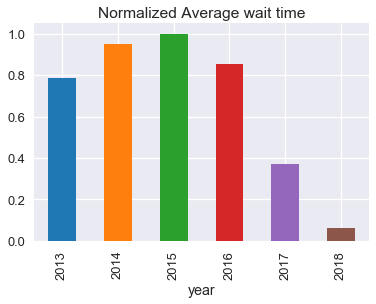

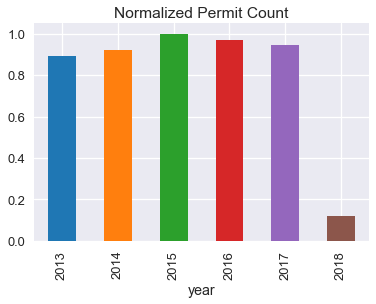

In [6]:
# Bar Plots of the same
(avg_days_month.groupby('year').mean()/avg_days_month.groupby('year').mean().max()).plot.bar()
plt.title('Normalized Average wait time')
plt.figure()
(count_appl_month.groupby('year').sum()/count_appl_month.groupby('year').sum().max()).plot.bar()
plt.title('Normalized Permit Count')

We can drop year 2018 as it has been only 2 months, so this is a different case where delays can at most be 59 days.
We will analyze 2017 to get more insight. 

There is drastic reduction in wait time for the year 2017, although the counts have remained at similar levels across the years. In 2016, there were many posts talking about permit delays causing major problems to builders and contractors. A few measures might have been taken in 2017, to reduce the delays. Tried to find out from the San Francisco city if this is true and what is the reason for improvement in issuing process. However, even if this was the case, there is another issue with the bar charts above. The charts will consider data points that have valid values for time_taken column. Time difference is valid only if the permit was issued at the time of data set download.

To validate this, let us, just fill issue date NaNs with today's date and see how the statistics change.

In [7]:
sfr = sfr.loc[sfr['file_dt'] < 'Oct 1, 2017',:] 

In [8]:
sfr = sfr.assign(issue_mod = sfr['issue_dt'].fillna(datetime.date.today()) )
sfr = sfr.assign(time_taken_filled = (sfr['issue_mod'] - sfr['file_dt']).dt.days )

In [9]:
np.round(sfr.time_taken_filled.describe(),2)

count    180811.00
mean         67.13
std         220.40
min           0.00
25%           0.00
50%           0.00
75%          13.00
max        1897.00
Name: time_taken_filled, dtype: float64

Compare the mean,standard deviation and max values of this with the earlier one! This is again hypothetical assuming all the pending ones are issued today. 

In [10]:
np.round(sfr.groupby('year').time_taken.describe(),2)

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,33859.0,26.44,104.74,0.0,0.0,0.0,5.0,1740.0
2014,34925.0,31.84,114.24,0.0,0.0,0.0,7.0,1421.0
2015,37991.0,33.61,101.30,0.0,0.0,0.0,9.0,1071.0
2016,36751.0,28.66,81.93,0.0,0.0,0.0,9.0,750.0
2017,27306.0,14.25,40.91,0.0,0.0,0.0,5.0,404.0


**Note:** These numbers do not look good in box plots because of median being at 0 and even 3rd quantile being at very small value

In [11]:
sfr.groupby('year').time_taken_filled.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2013,34852.0,74.352060,298.758620,0.0,0.0,0.0,6.0,1897.0
2014,36178.0,77.090138,264.594821,0.0,0.0,0.0,9.0,1532.0
2015,39662.0,73.352352,214.864529,0.0,0.0,0.0,14.0,1167.0
2016,39204.0,64.415850,161.745483,0.0,0.0,0.0,18.0,800.0
2017,30915.0,42.811063,91.280464,0.0,0.0,0.0,20.0,435.0


**Observations:**
The above two tables clearly show the difference in descriptive statistics with and without putting a hypothetical issue date to blank cells.

+ Just note how the count itself has increased by a few thousands in each year. In 2017, the difference is highest at 5000+, for obvious reason - it has not been long enough since the permits were filed.
+ Mean wait time and Standard deviation has blown up too.
+ But the number of permits with longer wait times are not big enough to shift the median. Surely, still at least 50% of them get processed on the same day, in every year.
+ The max column in the second table is hypothetical assuming pending ones were issued today.

In [12]:
def divide_time_taken(sfr) :
    perc_issued_table = np.empty((5,2),dtype=float)
    perc_issued_table[0,0] = round(100*(sfr.time_taken == 0).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[0,1] = round(100*(sfr.time_taken_filled == 0).sum()/sfr.time_taken_filled.count(),2)
    perc_issued_table[1,0] = round(100*(sfr.time_taken < 15).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[1,1] = round(100*(sfr.time_taken_filled < 15).sum()/sfr.time_taken_filled.count(),2) 
    perc_issued_table[2,0] = round(100*(sfr.time_taken < 91).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[2,1] = round(100*(sfr.time_taken_filled < 91).sum()/sfr.time_taken_filled.count(),2)
    perc_issued_table[3,0] = round(100*(sfr.time_taken < 182).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[3,1] = round(100*(sfr.time_taken_filled < 182).sum()/sfr.time_taken_filled.count(),2)
    perc_issued_table[4,0] = round(100*(sfr.time_taken < 366).sum()/sfr.time_taken.count(),2) # Count counts only non nulls
    perc_issued_table[4,1] = round(100*(sfr.time_taken_filled < 366).sum()/sfr.time_taken_filled.count(),2) # Count counts only non nulls
    return perc_issued_table

In [13]:
issue_stats = divide_time_taken(sfr)
print('Percentage of permits issued table, both without and with filling the issue date (Years 2013-2017)')
print('Number of records: {} for first column and {} for second column'.format(sfr.time_taken.count(),sfr.shape[0]))
pd.DataFrame(issue_stats,columns=['Percentage with dropping','Percentage with hypothetical issue date'],index=['same day','less than 15 days','less than 3 months','less than 6 months','less than a year'])

Percentage of permits issued table, both without and with filling the issue date (Years 2013-2017)
Number of records: 170832 for first column and 180811 for second column


,Percentage with dropping,Percentage with hypothetical issue date
same day,62.21,58.77
less than 15 days,80.74,76.29
less than 3 months,91.97,86.90
less than 6 months,95.19,90.26
less than a year,98.26,94.57


We will retain 'time_taken_filled' variable and drop 'time_taken'

In [14]:
# Henceforth time_taken is replaced with time_taken_filled 
sfr.loc[:,'time_taken'] = sfr.loc[:,'time_taken_filled']
sfr.drop('time_taken_filled',axis=1,inplace=True)

Wall time: 2min 33s


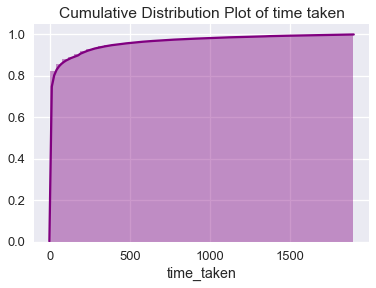

In [15]:
%%time
# The cumulative distribution of the time taken variable: This enables us to see the probability distribution
_ = sns.distplot(sfr['time_taken'],hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),color='purple')
_ = plt.title('Cumulative Distribution Plot of time taken')

In [16]:
weekday_cnt =  dict({'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0})
weekday_cnt_max =  dict({'Monday':0,'Tuesday':0,'Wednesday':0,'Thursday':0,'Friday':0})
for k,d in sfr.groupby(['year','month']) : 
    weekday_cnt_max[d.groupby('file_day')['time_taken'].count().idxmax()] = weekday_cnt_max[d.groupby('file_day')['time_taken'].count().idxmax()] + 1
    weekday_cnt[d.groupby('file_day')['time_taken'].count().idxmin()] = weekday_cnt[d.groupby('file_day')['time_taken'].count().idxmin()] + 1
print("Number of months for which each week day is least crowded:\n",weekday_cnt)
print("Number of months for which each week day is most crowded:\n",weekday_cnt_max)

Number of months for which each week day is least crowded:
 {'Monday': 31, 'Tuesday': 1, 'Wednesday': 13, 'Thursday': 5, 'Friday': 7}
Number of months for which each week day is most crowded:
 {'Monday': 7, 'Tuesday': 15, 'Wednesday': 8, 'Thursday': 14, 'Friday': 13}


Clear winner is Monday, among least crowded weekdays, contrary to the belief of Wednesday. We will validate this observation with statistical tests later.

There is no such clear majority for most crowded. We could still conduct a 2 sample t-test by grouping Monday and Wednesday into one group and Tuesday, Thursday, Friday into another group.

file_day
Friday       0.5764
Monday       0.6194
Thursday     0.5784
Tuesday      0.5932
Wednesday    0.5745
Name: time_taken, dtype: float64

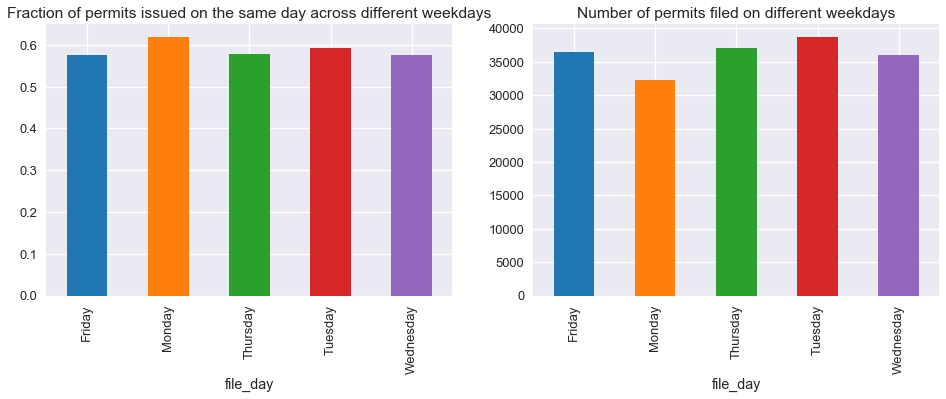

In [17]:
# Examinining if certain weekdays are efficient at processing wrt the permits they receive on that day.
_ = plt.figure(figsize=(16,5))
_ = plt.subplot(1,2,1)
(sfr.loc[sfr['time_taken']==0,:].groupby('file_day')['time_taken'].count()/sfr.groupby('file_day')['time_taken'].count()).plot.bar()
_ = plt.title('Fraction of permits issued on the same day across different weekdays')
_ = plt.subplot(1,2,2)
sfr.groupby('file_day')['time_taken'].count().plot.bar()
_ = plt.title('Number of permits filed on different weekdays')
np.round(sfr.loc[sfr['time_taken']==0,:].groupby('file_day')['time_taken'].count()/sfr.groupby('file_day')['time_taken'].count(),4)

**Observations:**
+ Mondays are most efficient.
+ Next place is Tuesday, although Thursday and Friday closely follow.
+ Wednesday is worst in issuing on the same day.
+ Interestingly, Mondays receive least number of applications, and Wednesday's receive next least number of applications, yet they are not efficient.
+ Tuesdays are most crowded as per the previous analysis and also in the second plot above. However, Tuesday's come second in issuing permits on the same day.

These differences could be statistically validated. Examples of certain tests in Inferential Statistics section. Tests for these weekday differences are similar.

In [18]:
def conv_quarter(v) :
    if v < 4 :
        q = 1
    elif v < 7:
        q = 2
    elif v < 10:
        q = 3
    else :
        q = 4
    return q

In [19]:
sfr = sfr.assign(quarter=sfr.month.apply(conv_quarter))

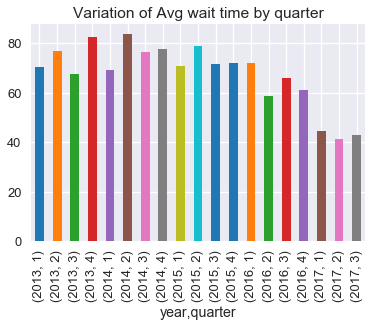

In [20]:
_ = sfr.groupby(['year','quarter']).time_taken.mean().plot.bar()
_ = plt.title('Variation of Avg wait time by quarter')

There is no visible pattern w.r.t quarters over years.

#### Revised Cost

Recall that missing entries were filled with minimum values, in the DataWrangling step. Visualize them to see how many have missing costs.

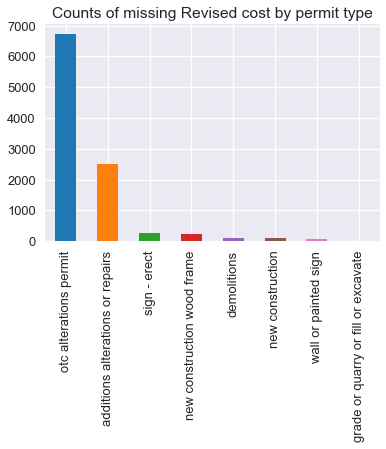

In [21]:
_ = sfr.loc[sfr.rev_cost==sfr.rev_cost.min(),'perm_typ_def'].value_counts().plot.bar()
_ = plt.title('Counts of missing Revised cost by permit type')

#### Revised Cost Vs Time Taken

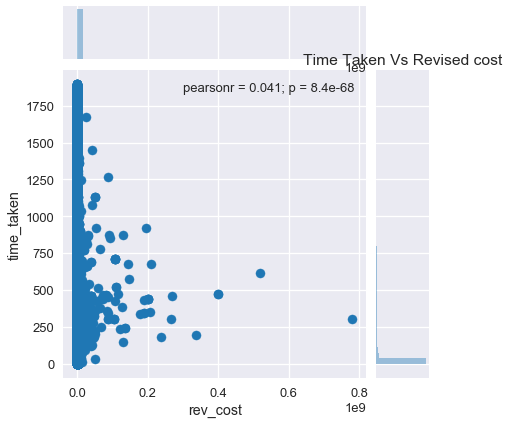

In [22]:
_ = sns.jointplot('rev_cost','time_taken',sfr)
_ = plt.title('Time Taken Vs Revised cost')

There is no apparent correlation between revised cost and time taken. Convert to Logarithm and see. Care is taken to see that log (0) does not happen

Percentage of zeros in Revised Cost: 5.55


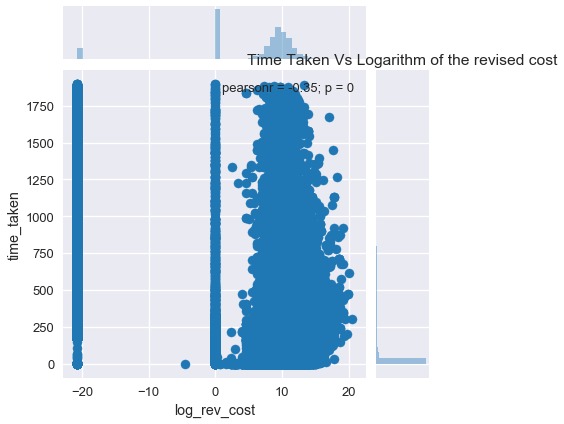

In [23]:
# Convert to Logarithm
print('Percentage of zeros in Revised Cost:',round(100*(sfr['rev_cost']==0).sum()/(sfr['rev_cost']==0).count(),2))
sfr['log_rev_cost'] = np.log(sfr['rev_cost']+0.000000001)
_ = sns.jointplot('log_rev_cost','time_taken',sfr)
_ = plt.title('Time Taken Vs Logarithm of the revised cost')

This graph reveals a few points:

+ The pearson correlation is negative. Looking at the scatterplot, it does not make practical sense, however, we need to keep in mind that correlation and causations are different. Hence as long as there is a correlation, it might help in modeling. 
+ The bin with close to zero values for revised cost have maximum count in the histogram of log_rev_cost. The bin with negative center value is corresponding to the NaNs in revised cost. To prevent error, they were substituted with very small values. 
+ One observation is, if min entries (that is zeros in this dataset) were substituted with 0.1, the correlation was -0.18, and if they were substituded with 0.000000001, it is -0.35. There are only 5.55% zeros, however 3% of these were NaN's replaced with mins in data wrangling step. 

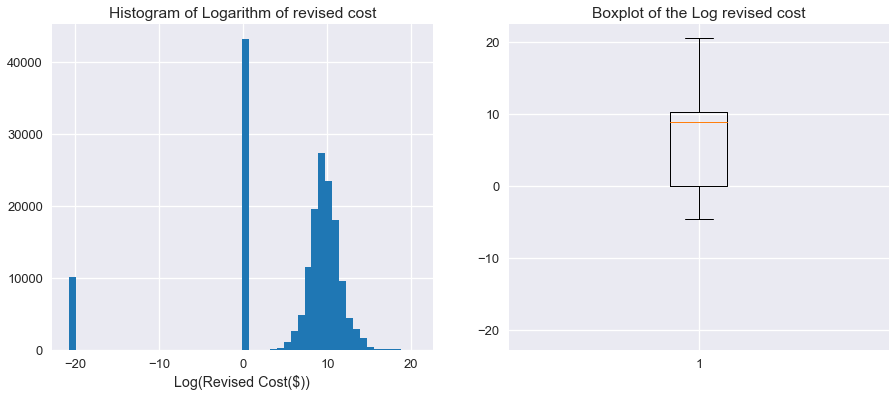

In [24]:
# Clearer view of Logarithm of revised cost
_ = plt.figure(figsize=(15,6))
_ = plt.subplot(1,2,1)
_ = plt.hist(sfr['log_rev_cost'],bins=50)
_ = plt.xlabel('Log(Revised Cost($))')
_ = plt.title('Histogram of Logarithm of revised cost')
_ = plt.subplot(1,2,2)
_ = plt.boxplot(sfr['log_rev_cost'])
_ = plt.title('Boxplot of the Log revised cost')

The valid entries portion of Logarithm of Revised cost is nearly normal. The left most bar corresponds to filled NaN's. The middle bar corresponds too small but non zero values entered. Both are not really valid. We are going to later on see how the absence of entry affects the time taken, for each permit type. Before that we will see w.r.t permit type alone.

#### Time Taken w.r.t Permit Type

In [25]:
sfr.groupby('perm_typ_def')['time_taken'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
new construction,301.0,577.870432,347.399031,60.0,335.00,468.0,772.00,1762.0
new construction wood frame,873.0,512.618557,383.645192,2.0,221.00,409.0,763.00,1854.0
demolitions,516.0,468.403101,390.497100,0.0,159.00,368.0,719.75,1841.0
additions alterations or repairs,12597.0,349.561324,332.695207,0.0,135.00,244.0,446.00,1892.0
wall or painted sign,433.0,257.136259,445.833850,0.0,3.00,30.0,231.00,1876.0
grade or quarry or fill or excavate,88.0,205.715909,391.390417,0.0,44.75,81.0,156.25,1820.0
sign - erect,2587.0,155.678005,339.272440,0.0,2.00,15.0,126.00,1895.0
otc alterations permit,163416.0,38.794806,179.077884,0.0,0.00,0.0,5.00,1897.0


**Observations:**
1) As expected, New construction permits take longer time to get issued. But their representation in the data set is very low. New construction minimum itself is 60 days, this might be as per rules for a new construction.     
2) Only one category of the permits, that is otc alteration permit has at least 50% of the applications issued on the same day.   
3) OTC alterations permit category is huge with > 90% of the records. Next big category is again additions alterations or repairs. But this second category does not get issued as fast. OTC alterations permit, as the name suggests, is "Over the Counter" permit. Ideally all of them have to be issued immediately.    

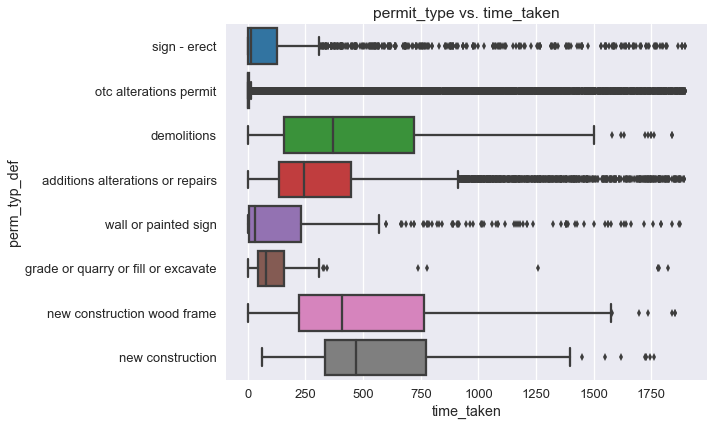

In [26]:
# create side-by-side boxplots for every permit type
_ = plt.figure(figsize=(10,6))
ax = sns.boxplot(y='perm_typ_def', x='time_taken', data = sfr, orient = 'h');
plt.title('permit_type vs. time_taken');
plt.tight_layout(pad=1)
plt.show()

Wall time: 982 ms


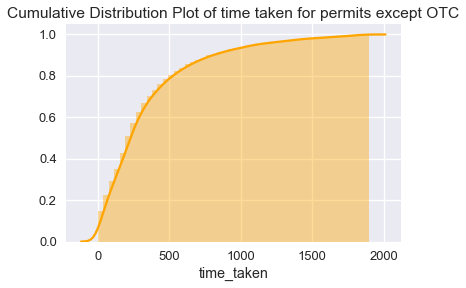

In [27]:
%%time
# The cumulative distribution of the time taken variable: This enables us to see the probability distribution
_ = sns.distplot(sfr.loc[sfr.perm_typ < 8 ,'time_taken'],hist_kws=dict(cumulative=True), kde_kws=dict(cumulative=True),color='orange')
_ = plt.title('Cumulative Distribution Plot of time taken for permits except OTC')

#### Plot of the Median Cost and Time Taken of a Building By Permit Type

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
additions alterations or repairs,12597.0,4.735438,12.966378,-20.723266,6.620073e+00,11.002100,12.429216,19.399238
demolitions,516.0,3.223060,13.116681,-20.723266,8.294050e+00,9.615805,11.002100,15.656060
grade or quarry or fill or excavate,88.0,11.004236,6.160834,-20.723266,1.057805e+01,12.899220,14.191652,16.510138
new construction,301.0,4.627215,17.579069,-20.723266,-2.072327e+01,15.830414,17.493529,20.475445
new construction wood frame,873.0,4.083812,15.443600,-20.723266,-2.072327e+01,13.167337,13.652992,18.627695
otc alterations permit,163416.0,5.835909,7.033198,-20.723266,1.000000e-09,8.744568,10.126631,17.034386
sign - erect,2587.0,4.990315,8.740877,-20.723266,6.907755e+00,7.937375,8.517193,11.918391
wall or painted sign,433.0,1.233053,10.878855,-20.723266,4.605170e+00,6.214608,7.244228,10.819778


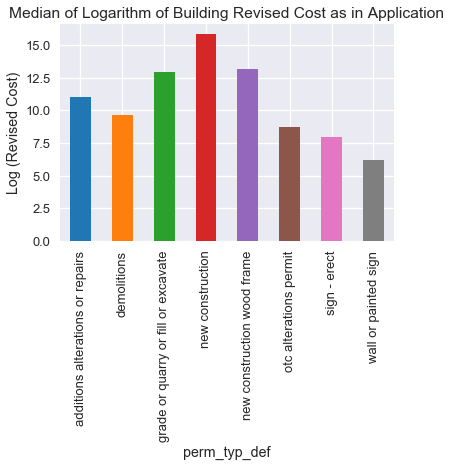

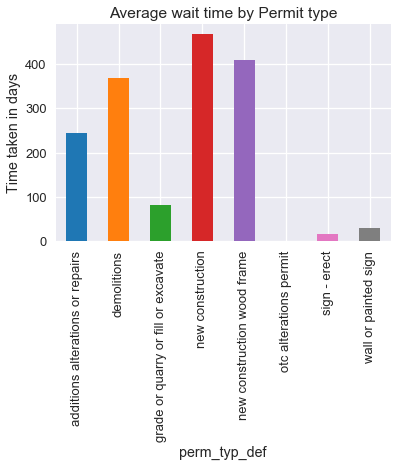

In [28]:
_ = sfr.groupby('perm_typ_def')['log_rev_cost'].median().plot.bar()
_ = plt.title('Median of Logarithm of Building Revised Cost as in Application')
_ = plt.ylabel('Log (Revised Cost)')
_ = plt.figure()
_ = sfr.groupby('perm_typ_def')['time_taken'].median().plot.bar()
_ = plt.title('Average wait time by Permit type')
_ = plt.ylabel('Time taken in days')
sfr.groupby('perm_typ_def')['log_rev_cost'].describe()

The new construction is high cost, but it takes highest average time. Its representation is low in the dataset, so it may not have much impact on the overal correlation properties between revised cost and time taken columns.
For others it is hard to conclude anything from these visualizations. **This justifies the use of statistical models to understand the relations and make predictions for future applications.**

Examine the Special cases Revised Cost = 0 and Revised Cost being too small, something like < 20$ need special analysis, to see the characteristics of average time taken.

In [29]:
(sfr.loc[sfr['rev_cost'] == 0,:]).groupby('perm_typ_def')['time_taken'].describe().sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
grade or quarry or fill or excavate,2.0,1801.500000,26.162951,1783.0,1792.25,1801.5,1810.75,1820.0
sign - erect,264.0,929.939394,512.986095,168.0,497.75,863.0,1384.75,1895.0
wall or painted sign,84.0,918.130952,509.715271,166.0,485.75,864.0,1378.00,1876.0
new construction wood frame,243.0,753.090535,402.330227,188.0,441.00,722.0,996.00,1854.0
new construction,97.0,729.268041,414.752801,190.0,441.00,608.0,971.00,1762.0
demolitions,118.0,703.593220,419.967118,39.0,396.00,535.5,980.00,1841.0
additions alterations or repairs,2499.0,613.557823,436.903200,166.0,274.00,455.0,842.00,1892.0
otc alterations permit,6725.0,453.833011,565.828886,0.0,0.00,184.0,852.00,1897.0


**Remarks:** If revised cost is 0, then except otc alterations permit,  all of them take a minimum of 1 year 2 months to be issued. Even the OTC alterations permits have less chances of getting issued on the same day.


In [30]:
sfr_sub = (sfr.loc[sfr['rev_cost'] < 20,:])
np.round(sfr_sub.loc[sfr_sub['rev_cost'] > 0,:].groupby('perm_typ_def')['time_taken'].describe(),2).sort_values('mean',ascending=False)

,count,mean,std,min,25%,50%,75%,max
perm_typ_def,,,,,,,,
additions alterations or repairs,507.0,236.31,315.04,0.0,63.0,126.0,261.0,1848.0
wall or painted sign,9.0,215.78,378.23,0.0,44.0,44.0,280.0,1182.0
sign - erect,10.0,186.10,185.49,0.0,16.0,189.0,362.0,362.0
grade or quarry or fill or excavate,6.0,41.67,20.41,0.0,50.0,50.0,50.0,50.0
otc alterations permit,42644.0,10.60,94.86,0.0,0.0,0.0,0.0,1896.0
demolitions,1.0,0.00,NaN,0.0,0.0,0.0,0.0,0.0


**Comments:** Notice that new construction permit types are absent in this table. Minimum time taken is 0, hence small entries are not the problem, absence of entry for the cost is the problem. 

**Recommendation:** Always put a valid entry for cost in applications.

#### Existing/Proposed Use variables

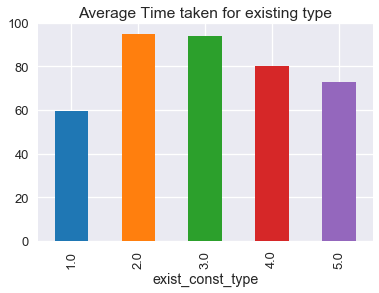

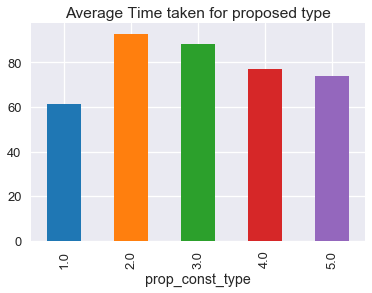

In [31]:
_ = sfr.groupby('exist_const_type').time_taken.mean().plot.bar()
_ = plt.title('Average Time taken for existing type')
_ = plt.figure()
_ = sfr.groupby('prop_const_type').time_taken.mean().plot.bar()
_ = plt.title('Average Time taken for proposed type')

#### Some more numerical EDAs

In [32]:
np.round(sfr.groupby('fire_only_permit')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
fire_only_permit,,,,,,,,
N,163802.0,71.63,226.86,0.0,0.0,0.0,14.0,1896.0
Y,17009.0,23.81,136.69,0.0,0.0,0.0,2.0,1897.0


In [33]:
np.round(sfr.groupby('site_permit')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
site_permit,,,,,,,,
N,176145.0,56.19,205.69,0.0,0.0,0.0,9.00,1897.0
Y,4666.0,480.16,331.83,0.0,237.0,371.5,620.75,1892.0


In [34]:
np.round(sfr.groupby('strct_notif')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
strct_notif,,,,,,,,
N,174648.0,58.67,209.99,0.0,0.0,0.0,9.0,1897.0
Y,6163.0,306.95,340.58,0.0,29.0,224.0,434.5,1892.0


The above 3 tables are self-explanatory.
#### Plansets Variable

In [35]:
np.round(sfr.groupby('plansets')['time_taken'].describe(),2)

,count,mean,std,min,25%,50%,75%,max
plansets,,,,,,,,
0.0,58456.0,12.72,114.01,0.0,0.0,0.0,0.0,1896.0
1.0,2.0,293.00,0.00,293.0,293.0,293.0,293.0,293.0
2.0,88297.0,124.16,282.74,0.0,1.0,11.0,90.0,1897.0
3.0,246.0,231.24,71.65,72.0,225.0,225.0,225.0,1195.0
4.0,3.0,178.33,163.66,55.0,85.5,116.0,240.0,364.0
6.0,2.0,327.00,0.00,327.0,327.0,327.0,327.0,327.0
20.0,1.0,1258.00,NaN,1258.0,1258.0,1258.0,1258.0,1258.0
9000.0,1.0,2.00,NaN,2.0,2.0,2.0,2.0,2.0


The 4 plansets out of 7 have very insignificant representation. The other 3 are interesting. The planset '0' is the fastest issued one and '3' is the slowest among these 3.

## **Conclusions from Exploratory Data Analysis:**     

1) What is the best day of the week to visit DBI, to file an application form? Is the popular belief “mid-week (Wednesday) is the least crowded and hence best to visit government or city agencies” true in this case?     

-Over the 4 years, it is found that in 25 out of 48 months, Monday has been the week day with least number of permit applications. Wednesday was least crowded only in 8 months. It is also interesting to know that while Tuesday was the week to receive maximum number of applications in 12 months, it is not a clear winner. So, there is not a clear "Most" crowded week day.

2) What type of permits are mostly issued on the same day of filing?

"OTC alterations permits" as the name suggests, are issued mostly on the same day of filing. More than 75% of these are issued within a week. 

3) Which types take least average time issue if not issued on the same day?   

Once again the answer is OTC alterations permits. They are 89% of the total permit applications, and they have very low average wait time.

4) Is there any particular quarter of each year which has higher application counts or average wait times? Can it be justified from the business knowledge?         

No.

5) How does the permit times vary across plansets?   
There are 7 different plansets, of which 3 seem significant. They are highly variable

6) How is permit times related to cost?   
We looked at permit times' relationship with revised cost, as that is the most recent estimate. There is no clear relationship when the cost is some reasonable number. However, if the cost is not entered or entered too low to believe, there is a greater possibility of delay in issuing.

7) How is the wait time related to a few other columns?     
Many statistics are generated above.

## Inferential Statistics:        

  1) Assume there is a claim by the DBI. "65% of **all** the permit applications are processed on the same day." Can we formulate a hypothesis test? What are the null and alternate hypothesis? What is the significance level you want to chose? {Keep in mind that data we have is entire population for year 2013 onwards. Hence the tests have to be performed on a randomly chosen subset assuming entire population is not available. This is true for next two questions as well}   
  1a) Estimate the proportion that get processed the same day corresponding to 95% confidence level.       
  2) Is there a statistically significant difference between mean wait times of fire only permits and not fire only permits?      
  3) Can we do Anova test to verify variability across mean wait times for various permit types? If yes, demonstrate. If no, justify.
  


**Simulating restricted availability of the population**  
We have entire population (records of applications) for the years 2013-2017 Sept 30th. Hence we can readily verify it by the pandas built-in function describe. However, we want to simulate the scenario of having a subset of the population and then conduct statistical tests to answer the above questions. This can happen in real life.


Suppose DBI does not let you download all 150k+ records, but only 7500 records once a day and you want to know if their claim is true, before visiting them today!

In [36]:
# Choose 7500 random records without replacement and use this for all the three tests
n=7500
indices = np.random.choice(a=sfr.index,size=n,replace=False)

**Answer to 1:**    


We can apply a one sample test for [**population proportion**](https://onlinecourses.science.psu.edu/stat500/node/41)

**Null Hypothesis H0:** DBI processes 65% permit applications the same day.    
**Alternate Hypothesis HA:** DBI normally processes a different percentage of applications than 65% the same day and difference is statistically significant.       

1. Independence: The samples are independent and without replacement, with sample size < 5% of population
2. Sample size/skew: Expected value of success: np >= 10, Expected value of failure: n(1-p)>=10 are satisfied for n=7500, p=0.65

Hence the central limit theorem kicks in. 
DBI can not process less than 0% applications. Hence this is a skewed distribution.      
This is a two sided z-test, as stated in HA.       
Let us have significance level alpha = 0.01 

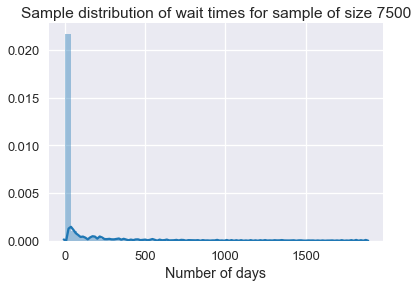

In [37]:
time_taken_sample = sfr.time_taken[indices]
_ = sns.distplot(time_taken_sample,hist=True)
_ = plt.title('Sample distribution of wait times for sample of size 7500')
_ = plt.xlabel('Number of days')

In [38]:
# The Hypothesis test code. time_taken_sample is the array containing wait times.
# Claimed by DBI, the null proportion
claimed_proportion = 0.65
# Observed proportion, the alternate proportion
observed_proportion = (time_taken_sample == 0).sum()/time_taken_sample.shape[0]
print("Observed proportion of permits issued same day is {:.2f}% ".format(100*observed_proportion))

Observed proportion of permits issued same day is 58.49% 


This could be just a chance. Hence let us find the z score:

In [39]:
zsc = (claimed_proportion - observed_proportion)/np.sqrt(claimed_proportion*(1-claimed_proportion)/n)
print("Z score: {:.2f}".format(zsc))
pval_test1 = 2*(1 - stats.norm.cdf(abs(zsc)))
print("p-value is",pval_test1)

Z score: 11.81
p-value is 0.0


The Z score of 2.6+ corresponds to a p-value < alpha = 0.01. Hence this difference in proportion is statistically significant. Therefore we reject the null hypothesis that 65% of the applications are processed the same day in favor of alternate hypothesis.     

1a) Finding confidence interval corresponding to the observed proportion:

In [40]:
# Z score for 95% CI is 1.96
z_95 = 1.96
# From the formula for margin of error,
margin_error = z_95 * np.sqrt(observed_proportion*(1-observed_proportion)/n)
print("Margin of error for population proportion: {:.4f}".format(margin_error))
# By definition, confidence interval:
ci = (100*round(observed_proportion-margin_error,4),100*round(observed_proportion+margin_error,4))
print('95% confidence interval of the population proportion:',ci,'%')

Margin of error for population proportion: 0.0112
95% confidence interval of the population proportion: (57.379999999999995, 59.61) %


**Answer to 2:**

Here we are comparing mean wait times between two samples. We would need a 2 sample t-test/z-test

H0: Average wait times are same whether it is fire only permit or not
HA: Average wait times are different

Again alpha = 0.01

In [41]:
test2 = pd.DataFrame(sfr.fire_only_permit[indices].copy())
test2 = test2.assign(time_taken_sample = sfr.time_taken[indices].copy())
sample_stats = test2.groupby('fire_only_permit').time_taken_sample.describe()
sample_stats

,count,mean,std,min,25%,50%,75%,max
fire_only_permit,,,,,,,,
N,6806.0,75.966794,236.45626,0.0,0.0,0.0,16.0,1884.0
Y,694.0,34.733429,181.60208,0.0,0.0,0.0,2.0,1814.0


In [42]:
# Compute combined standard deviation
comb_sigma = np.sqrt((sample_stats.loc['N','std']**2 / sample_stats.loc['N','count'])
                     + (sample_stats.loc['Y','std']**2 / sample_stats.loc['Y','count']))

# Z-score
zsc2 = (sample_stats.loc['N','mean'] - sample_stats.loc['Y','mean'])/comb_sigma
print("Z score for 2 sample z test: {:.2f}".format(zsc2))

# p-value
pval_test2 = 2*(1 - stats.norm.cdf(abs(zsc2)))
print("p-value for 2 sample test is",pval_test2)

Z score for 2 sample z test: 5.52
p-value for 2 sample test is 3.3308779956442436e-08


The high value for z score above makes us reject H0 in favor of HA

**Answer to 3:**

Can we do ANOVA test to compare the average wait time across permit types? May be. Let us check it out.

In [43]:
test3 = pd.DataFrame(sfr.perm_typ[indices].copy())
test3 = test3.assign(time_taken_sample = sfr.time_taken[indices].copy())
sample_stats3 = test3.groupby('perm_typ').time_taken_sample.describe()
sample_stats3

,count,mean,std,min,25%,50%,75%,max
perm_typ,,,,,,,,
1,9.0,489.444444,353.404906,75.0,368.00,415.0,608.00,1310.0
2,33.0,516.151515,333.997859,69.0,241.00,418.0,817.00,1419.0
3,552.0,349.498188,333.885719,7.0,130.00,242.0,454.00,1822.0
4,129.0,151.426357,329.495727,0.0,2.00,14.0,128.00,1884.0
5,2.0,411.500000,519.723484,44.0,227.75,411.5,595.25,779.0
6,21.0,547.619048,432.080835,50.0,166.00,522.0,862.00,1353.0
7,19.0,251.842105,437.720518,0.0,2.00,53.0,233.50,1660.0
8,6735.0,43.078248,194.379008,0.0,0.00,0.0,5.00,1882.0


The conditions for doing ANOVA test:    
+ The observations should be independent within and across groups : This is met.    
+ The data within each group are nearly normal: This is not met as can be seen from the asymmetric percentile values in the above table.   
+ The variability across the groups is about equal (and use graphical diagnostics to check if these conditions are met.): Without graphical diagnostics, it is evident from the "std" column that variability is not met.  
[Conditions required for ANOVA test](https://www.coursera.org/learn/inferential-statistics-intro/supplement/ctr7d/lesson-learning-objectives)* are not satisfied. Hence we can not conduct ANOVA test for comparing means average time across permit types.         
* : You might need to login and enroll into the course to access the link

### Conclusions From Inferential Statistics Tests:

1. There is no sufficient statistical evidence to believe the DBI's claim that on an average it processes 65% of the permit applications the same day.    
2. There is enough statistical evidence to believe that average wait times for fire only permit and the normal permits are not the same.    
3. We could not conduct statistical tests to compare the average wait times across various permit types because conditions required for ANOVA test were not satisfied

In [44]:
# Pass on the dataframe to Modeling notebook
%store sfr

Stored 'sfr' (DataFrame)
